In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# Standard library imports
import os
import time

# Third-party imports
import cv2
import geojson
import numpy as np
import openslide
import pandas as pd

# Local application/library specific imports
from data_utils import (adjust_artery_coords_by_boundry, cnt_polygon_test, clean_coord, 
                        get_border_of_ann, get_border_of_cnt, get_cnts_inside)
from measure_utils import measure_thickness
from vis_utils import plot_artery_ann, save_img, imshow_k_in_row
from skimage import morphology


In [2]:
DIR_WSI = "/Users/jinzhou/Desktop/Paper_MIA/data/wsi"
DIR_ANN = "/Users/jinzhou/Desktop/Paper_MIA/data/ann_geojson"
DIR_TEST = "/Users/jinzhou/Desktop/Paper_MIA/test" # parent folder for input and gt in testset

DIR_DL = "/Users/jinzhou/Desktop/Paper_MIA/dl_output" # folder for DL predictions on testset

DIR_SAVE_RESULTS = "/Users/jinzhou/Desktop/Paper_MIA/results"
DIR_SAVE_FIGURE = "/Users/jinzhou/Desktop/Paper_MIA/results/figures"

In [3]:
def clean(img):
    # removing small holes and objects
    small_holes_th = np.count_nonzero(img) / 20
    small_objects_th = np.count_nonzero(img) / 20
    img_rmh = morphology.remove_small_holes(img, area_threshold=small_holes_th)
    img_rmo = morphology.remove_small_objects(img_rmh, min_size =small_objects_th)
    res = np.uint8(img_rmo*255)
    return res

def get_largest_cnt(contours):
    largest_contour = None
    max_area = 0
    max_area_index = 0
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            largest_contour = contour
            max_area = area
            max_area_index = i
    return largest_contour, max_area_index

In [4]:
def get_three_cnts(img):
    img_outer = (img > 0) * 255 # area under the outer contour of media
    img_middle = (img > 85) * 255 # area under the outer contour of intima
    img_inner = (img > 170) * 255 # area under the outer contour of lumen
#     imshow_k_in_row([gt, img, img_outer, img_middle, img_inner])
    img_outer = clean(img_outer)
    img_middle = clean(img_middle)
    img_inner = clean(img_inner)
#     imshow_k_in_row([gt, img, img_outer, img_middle, img_inner])
    cnt_outers, _ = cv2.findContours(img_outer.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt_outer, _ = get_largest_cnt(cnt_outers)
    cnt_outer = cnt_outer.squeeze()
    cnts_middle, _ = cv2.findContours(img_middle.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts_middle = [cnt.squeeze() for cnt in cnts_middle]
    cnts_inner, _ = cv2.findContours(img_inner.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts_inner = [cnt.squeeze() for cnt in cnts_inner]
    
    return cnt_outer, cnts_middle, cnts_inner

/Users/jinzhou/anaconda3/envs/cv/lib/python3.7/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


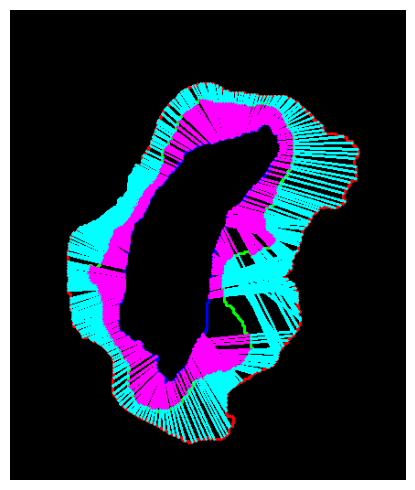

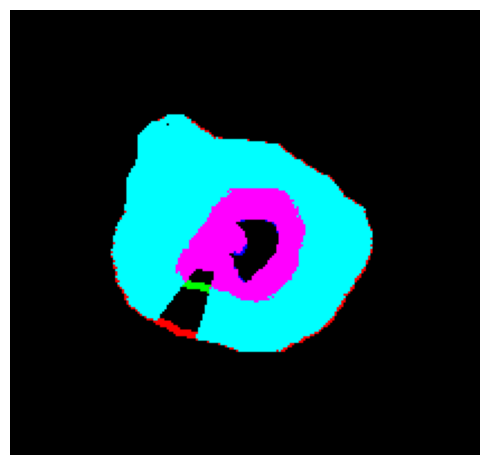

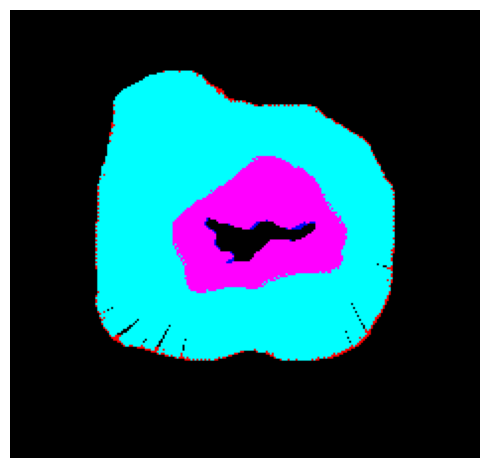

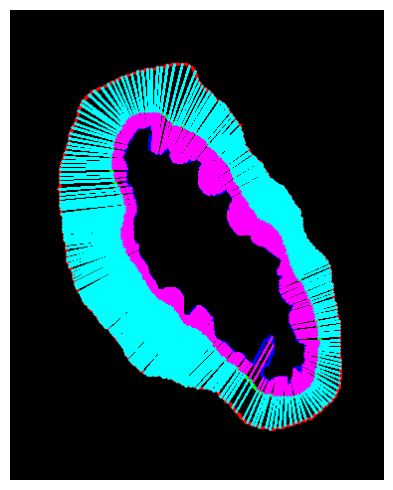

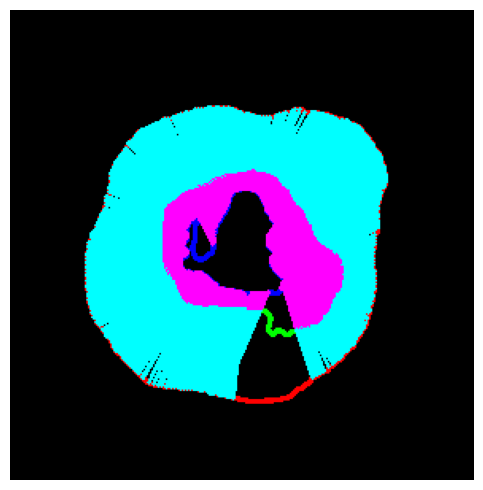

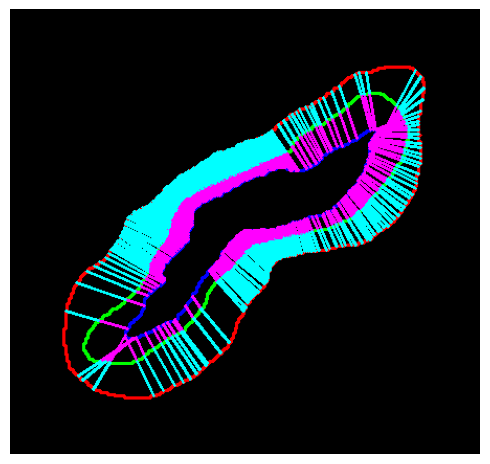

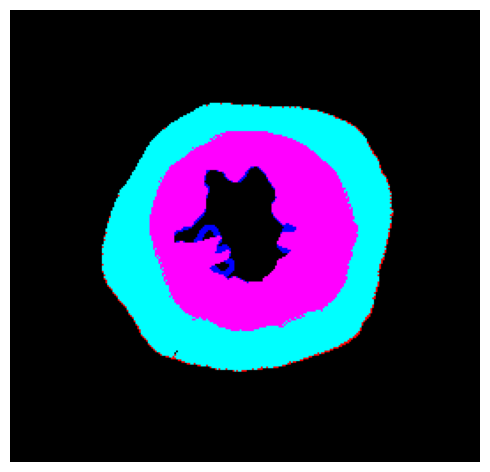

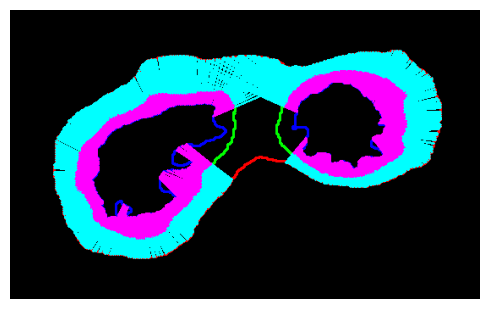

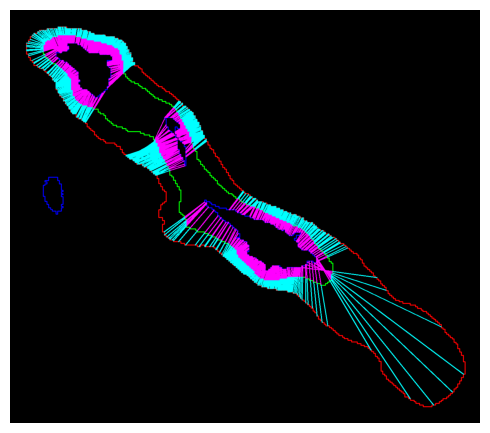

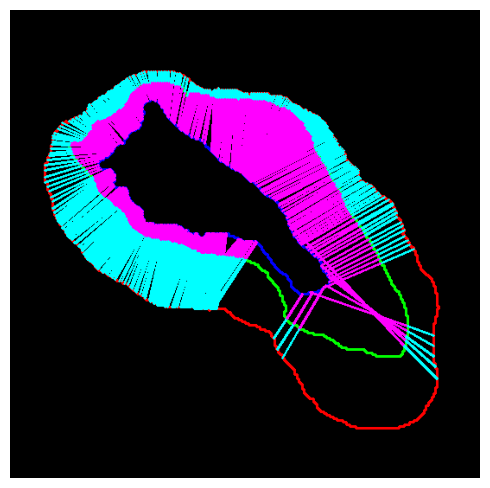

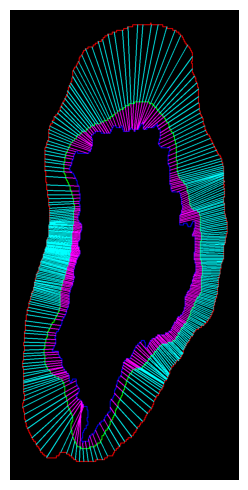

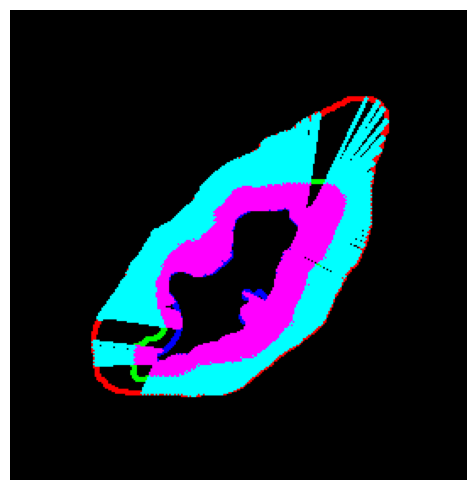

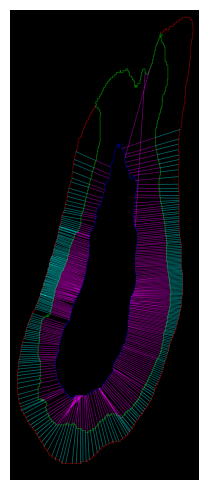

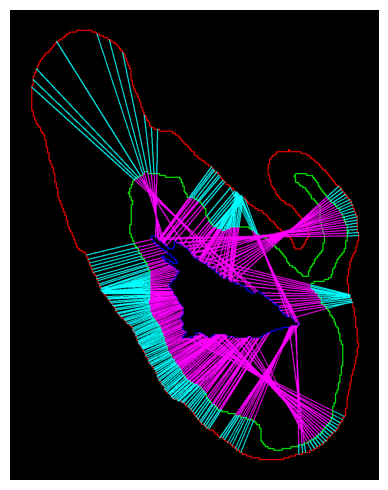

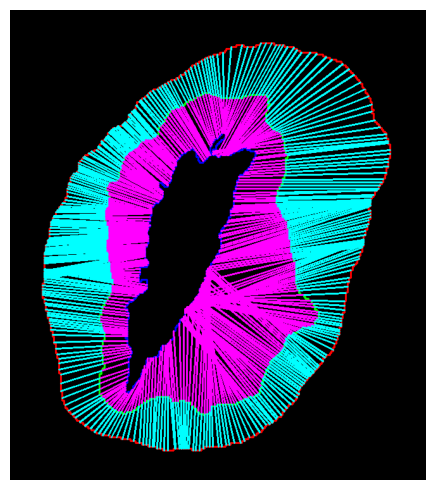

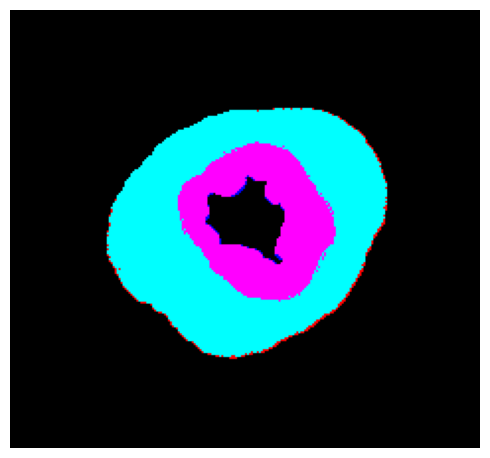

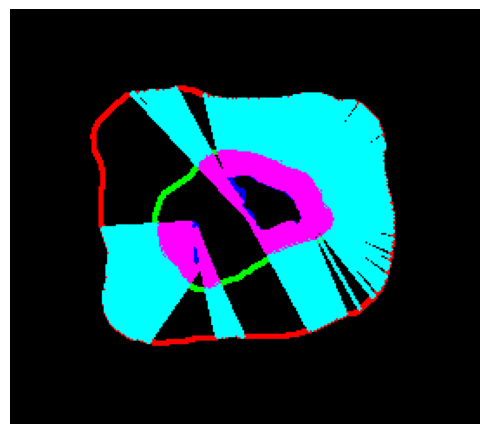

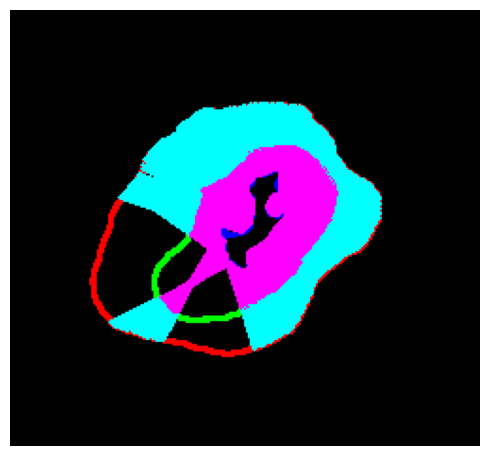

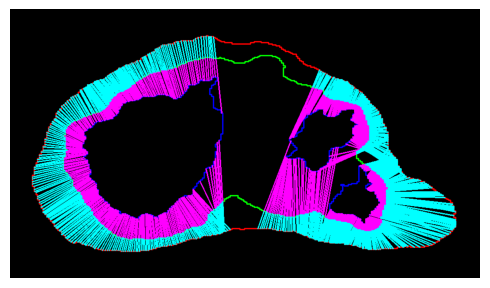

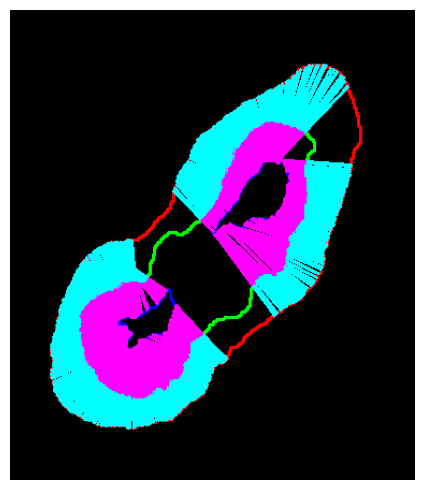

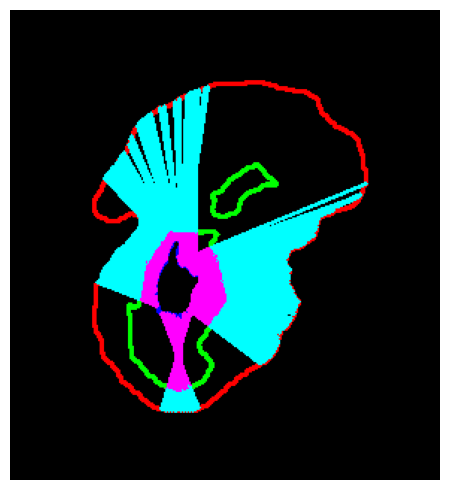

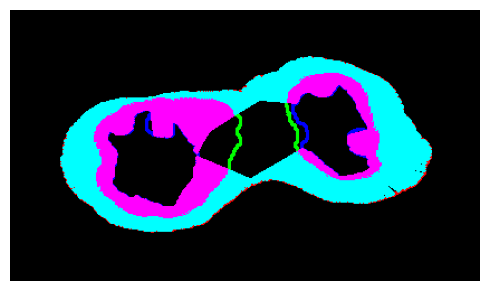

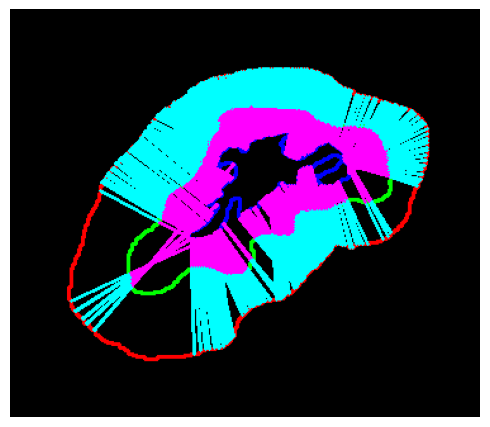

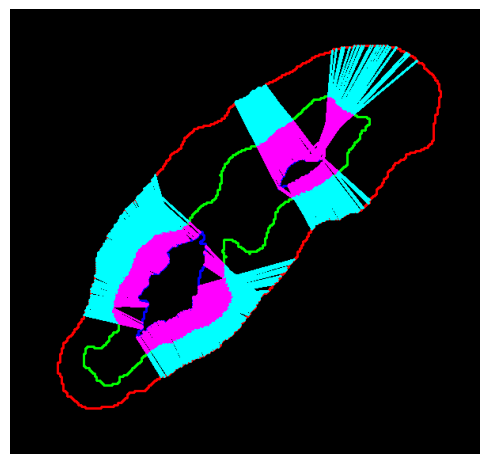

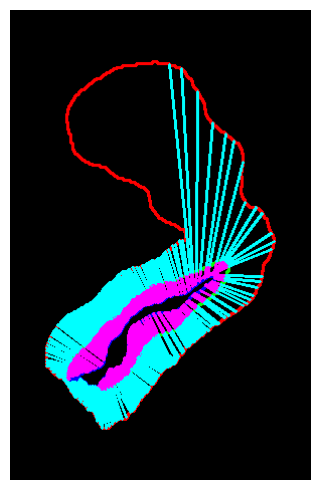

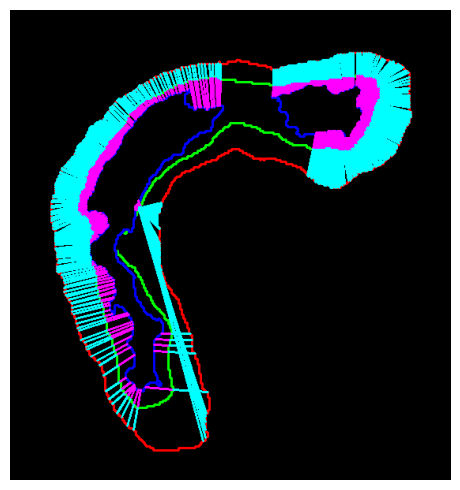

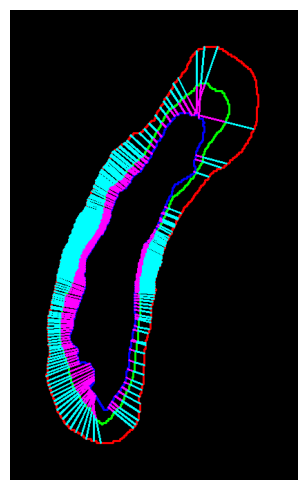

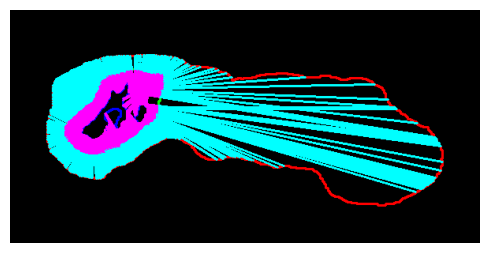

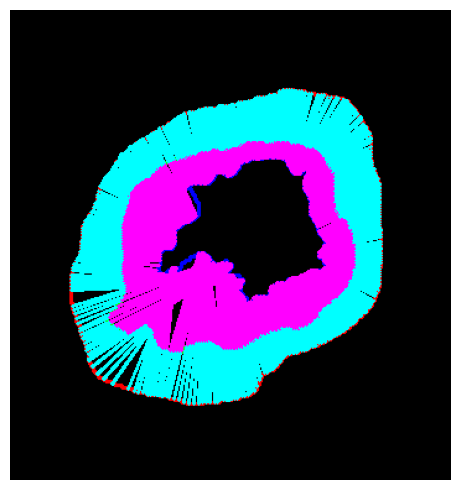

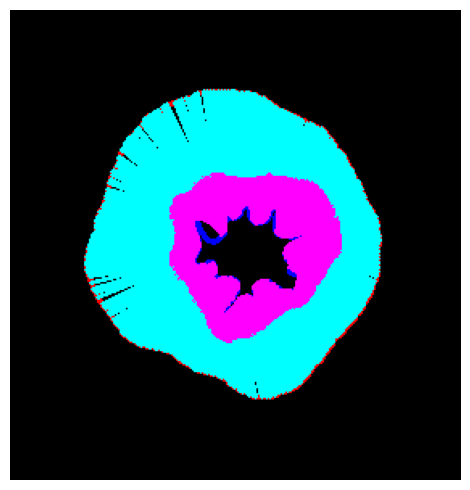

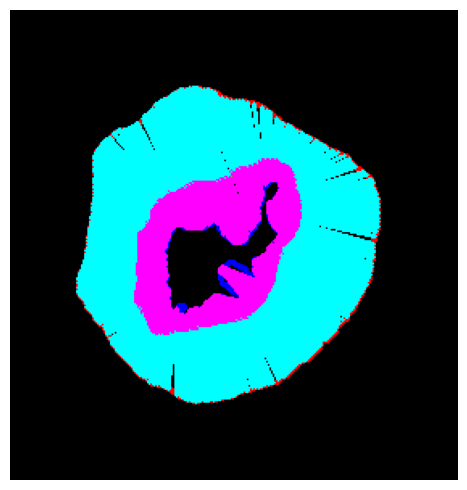

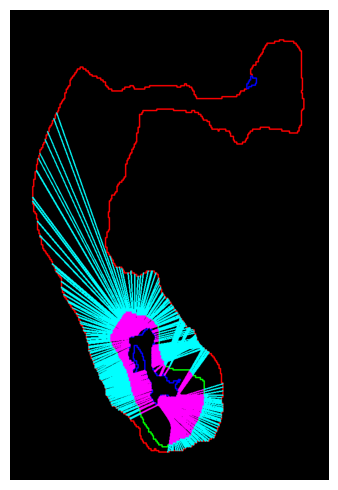

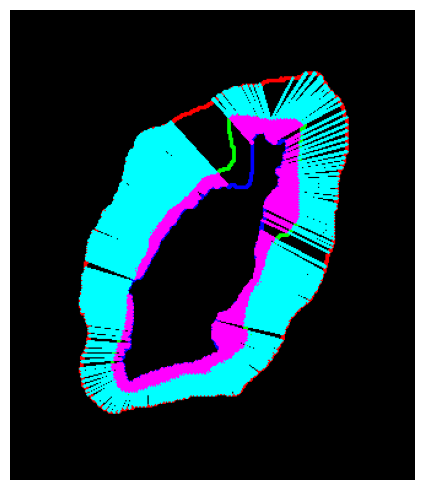

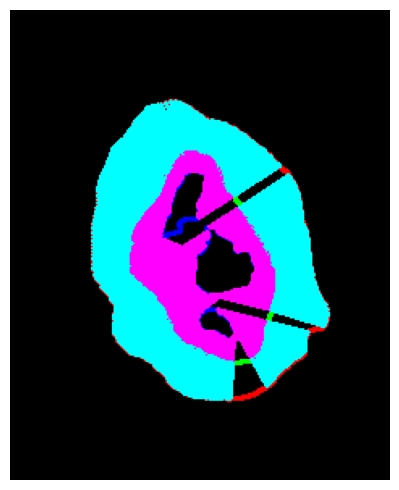

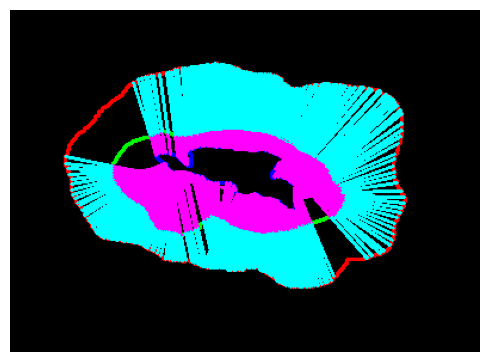

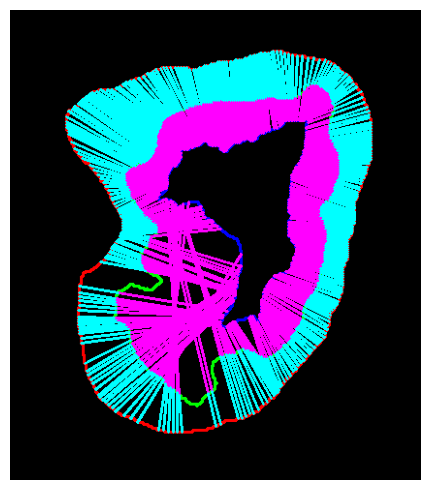

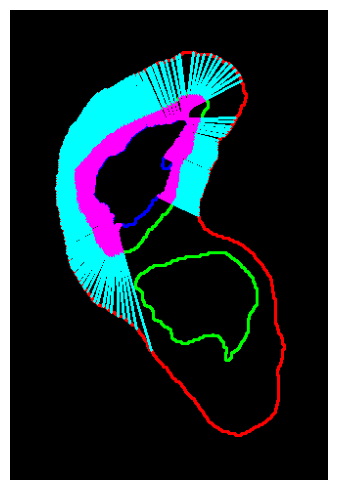

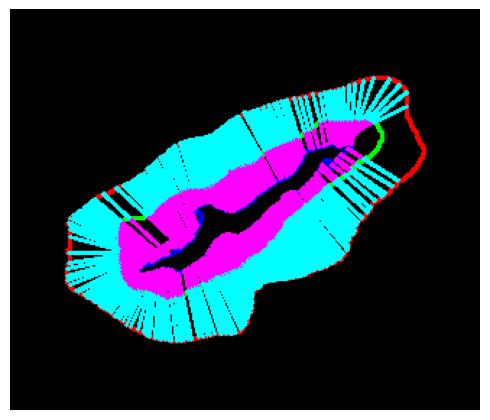

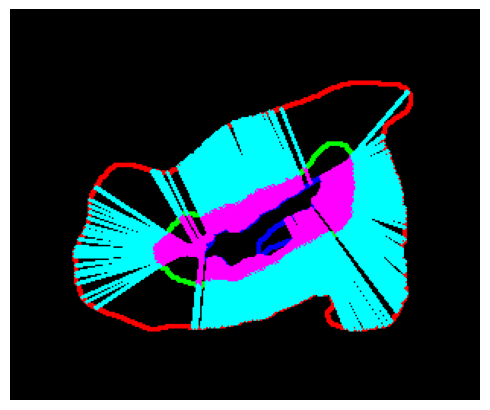

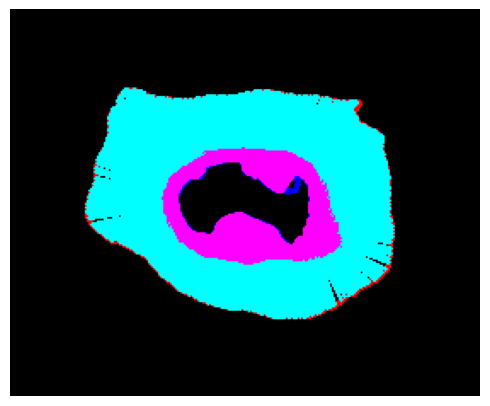

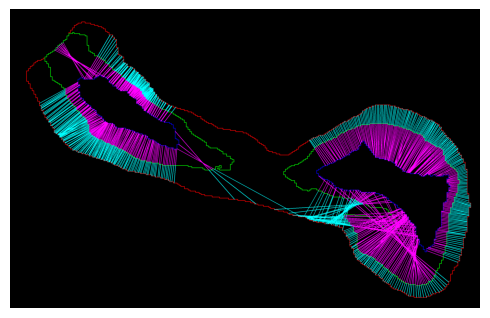

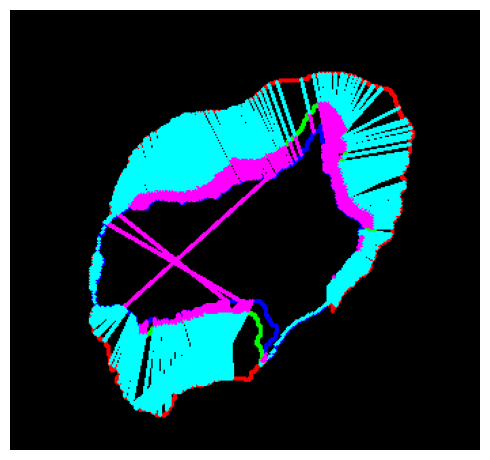

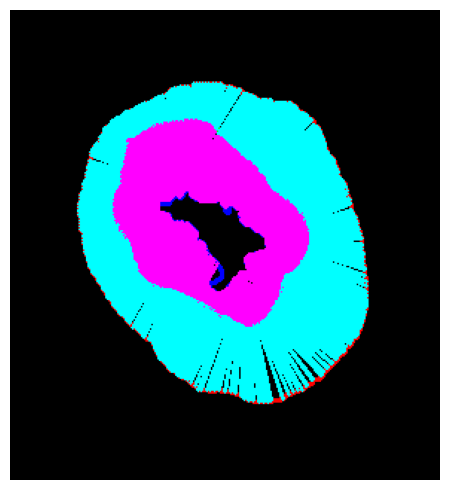

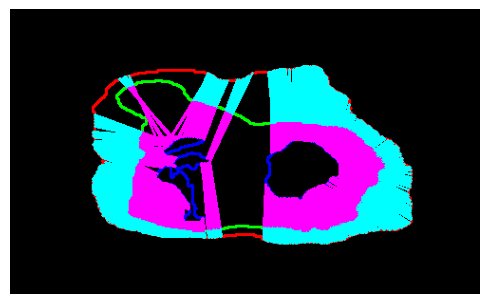

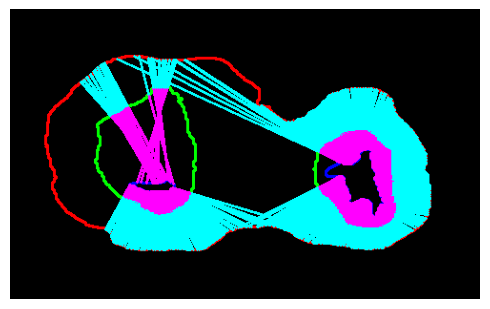

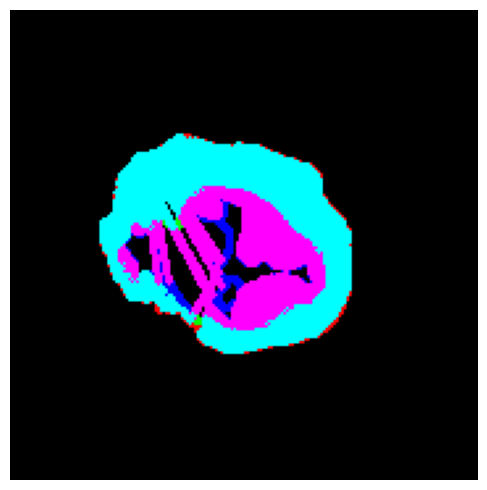

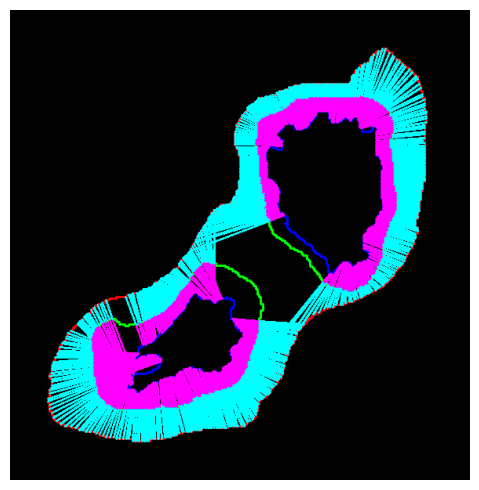

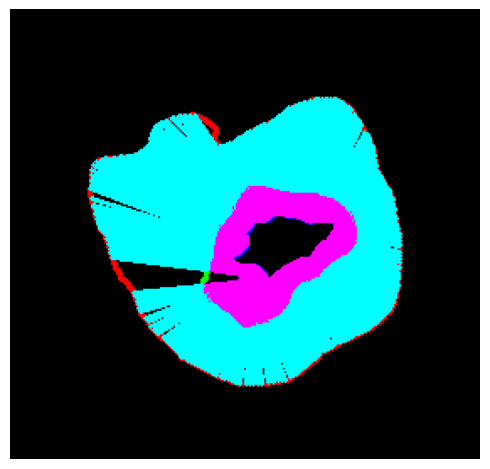

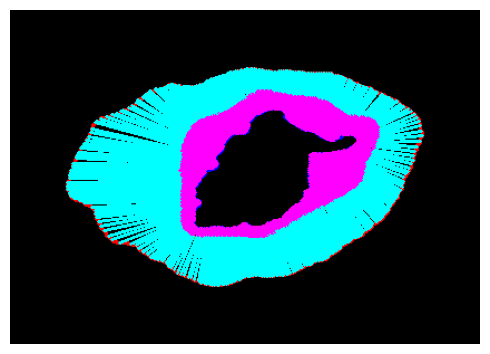

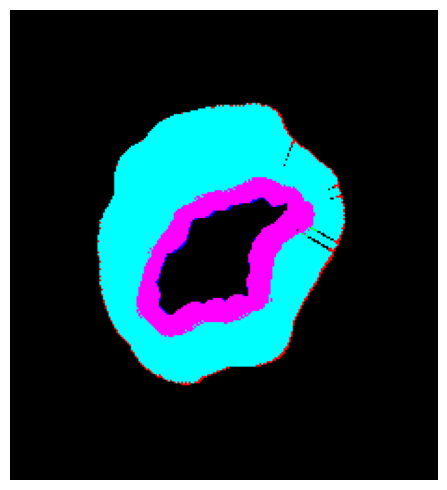

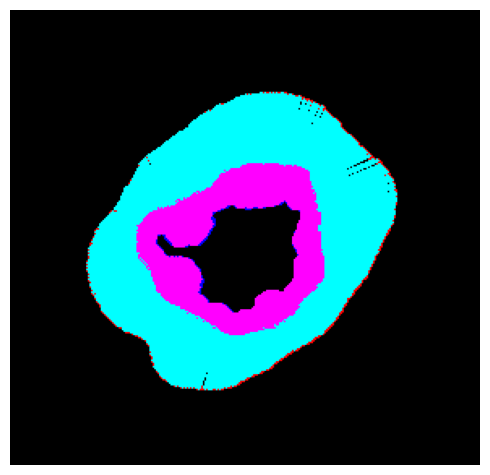

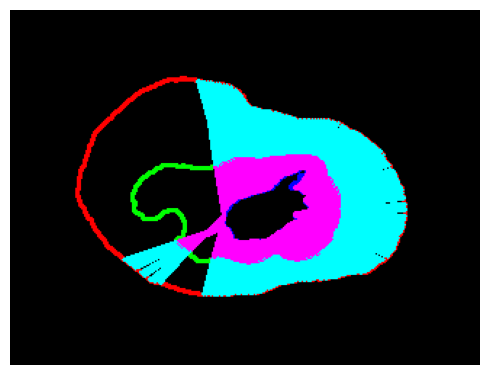

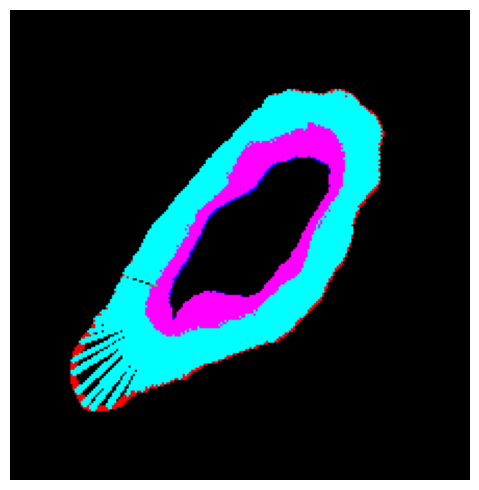

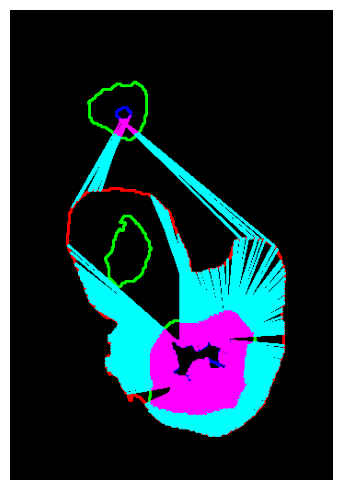

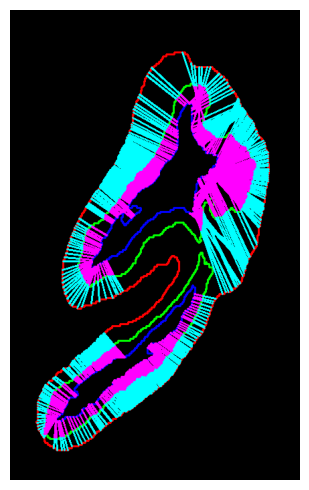

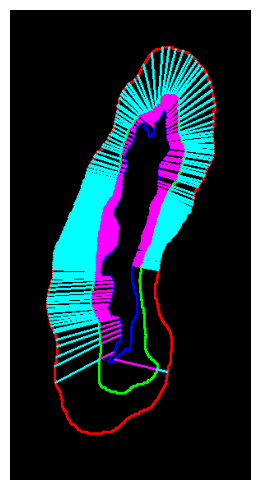

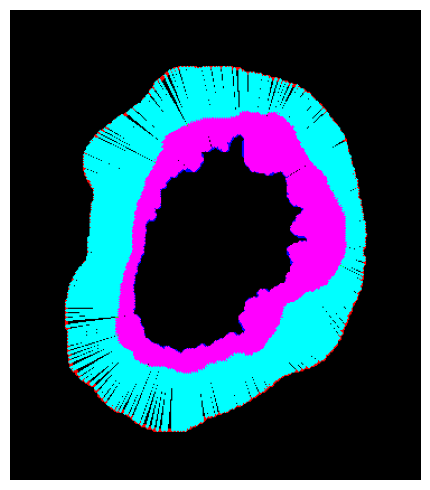

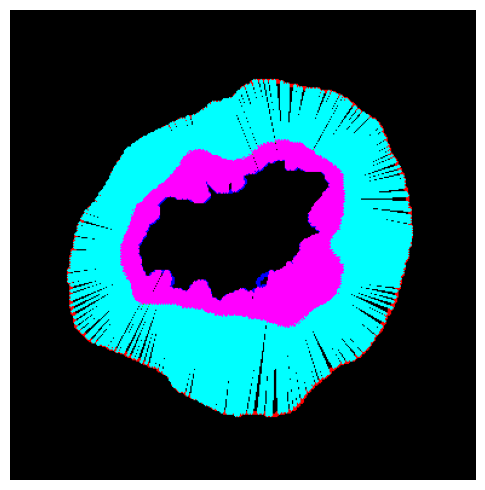

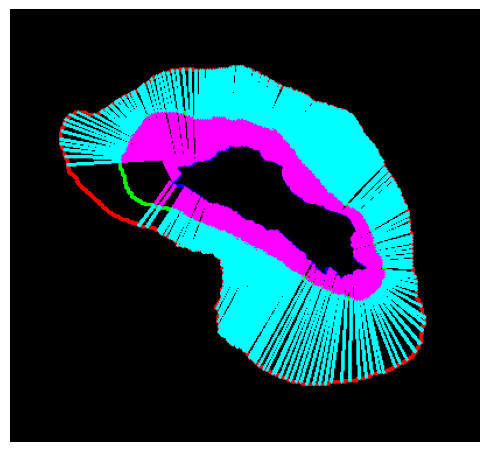

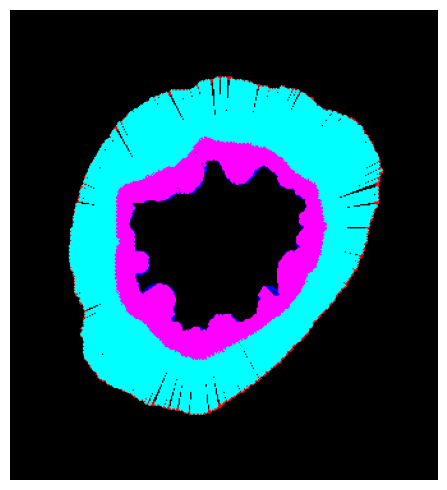

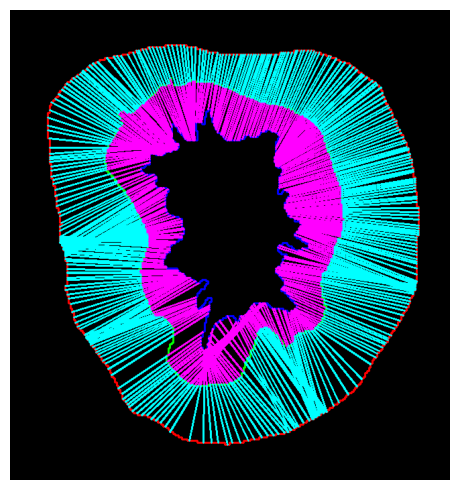

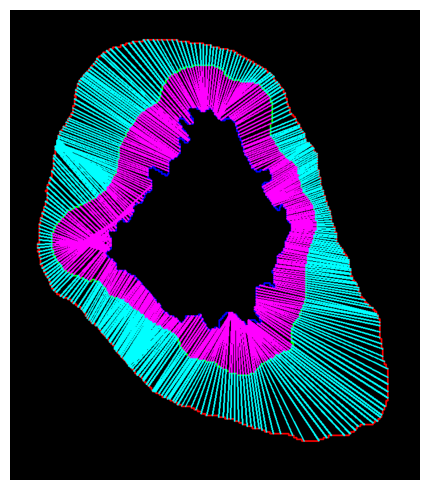

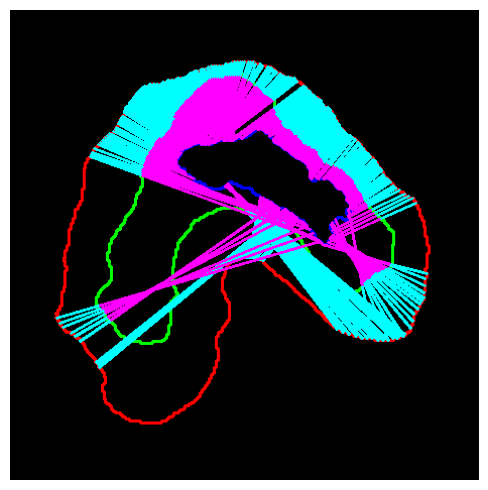

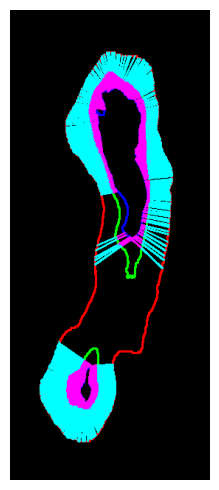

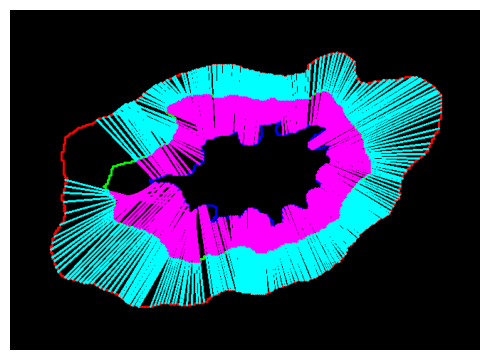

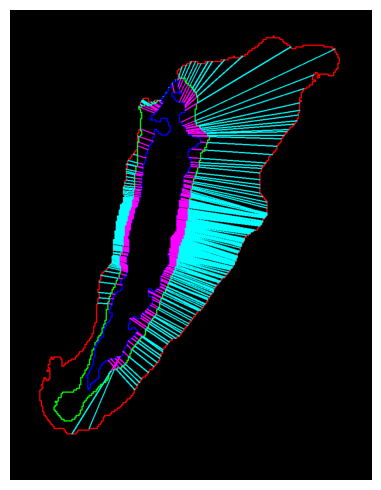

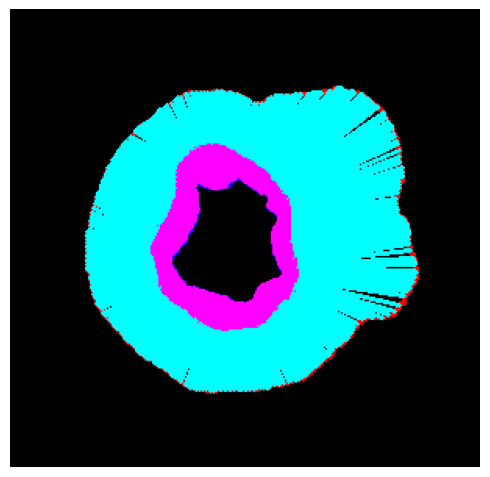

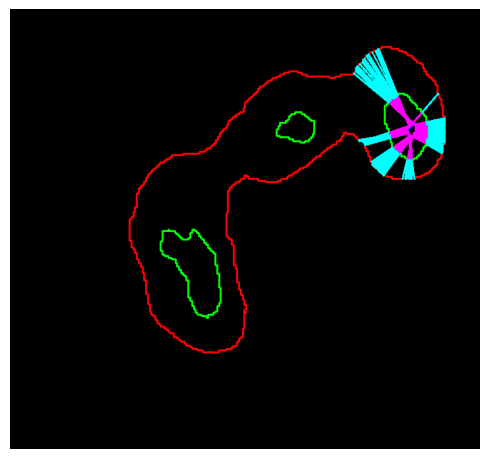

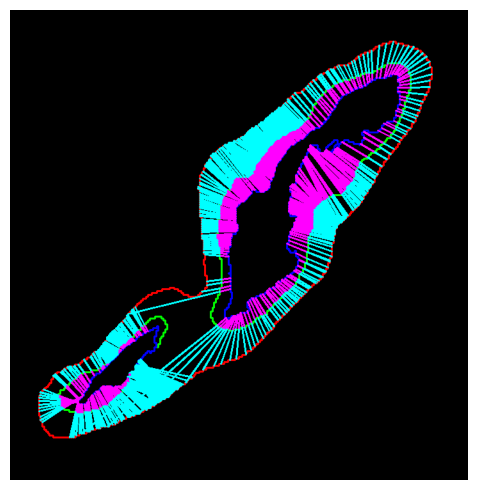

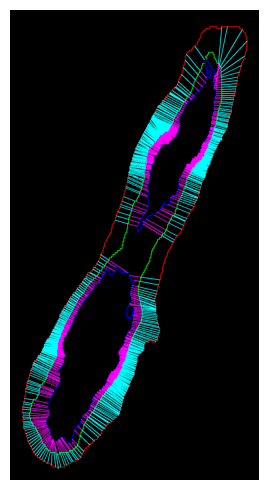

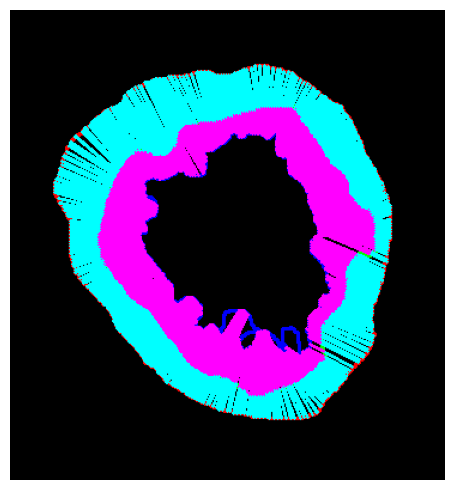

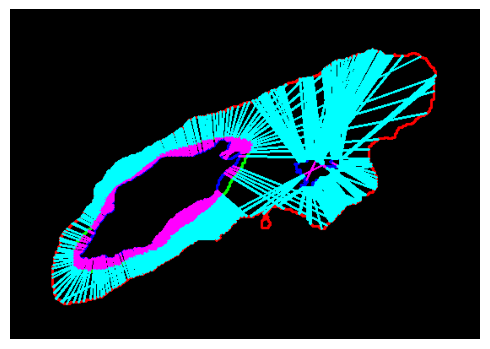

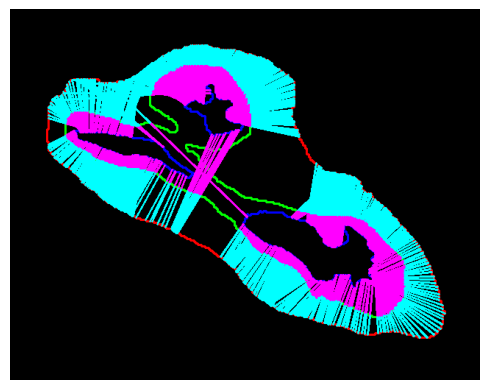

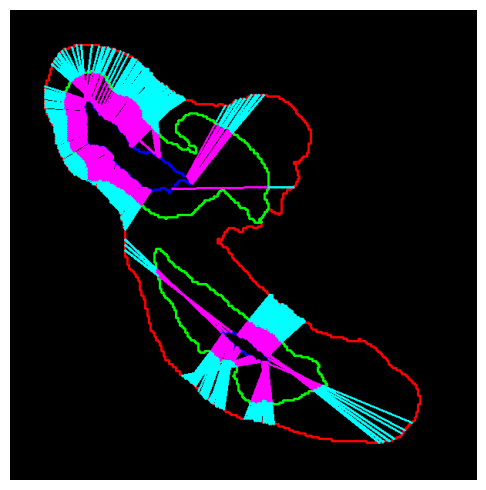

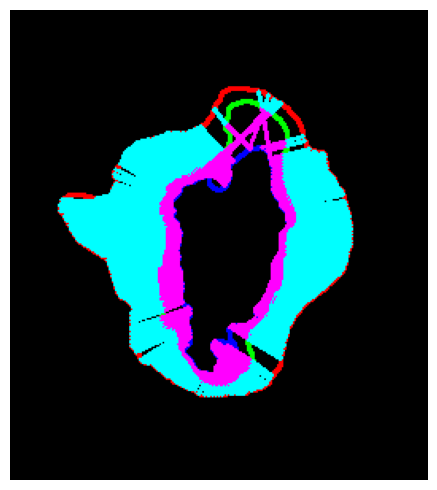

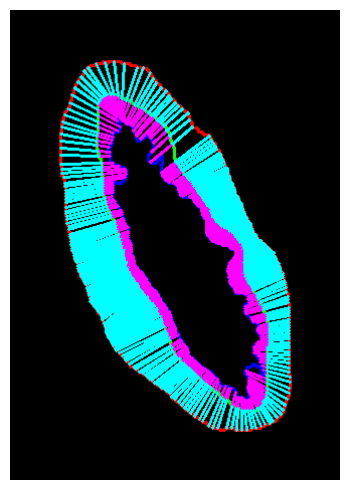

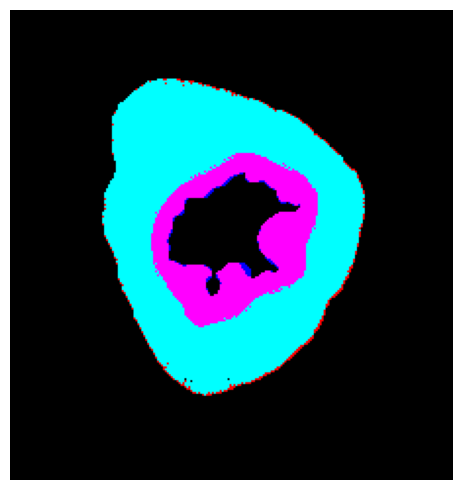

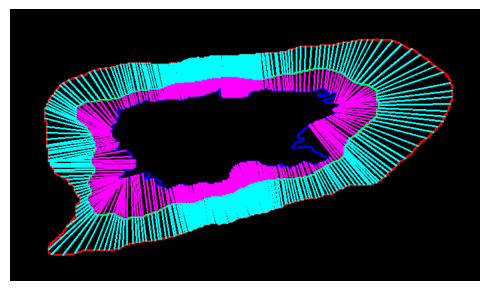

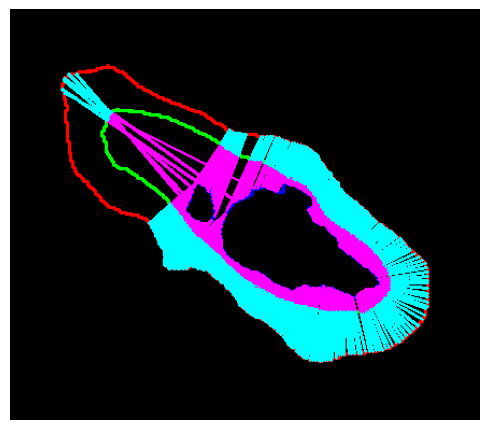

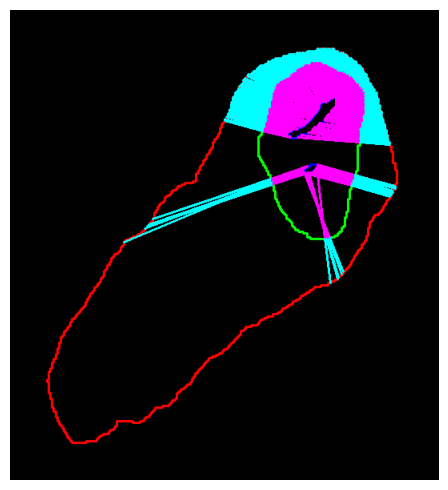

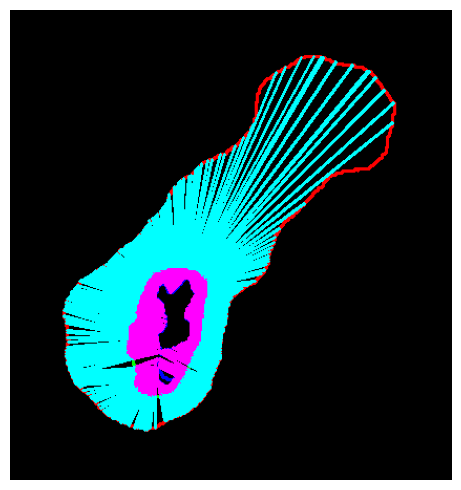

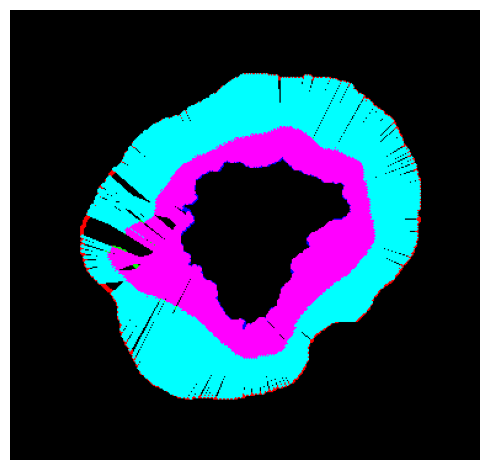

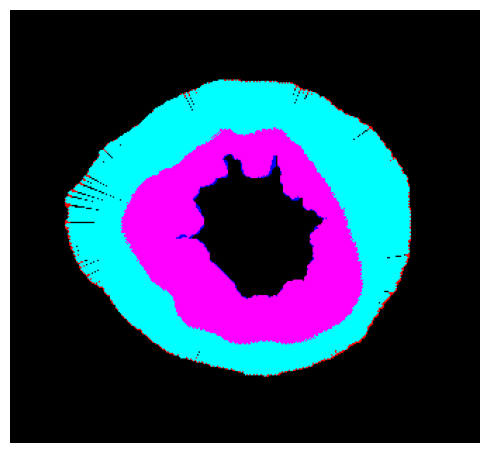

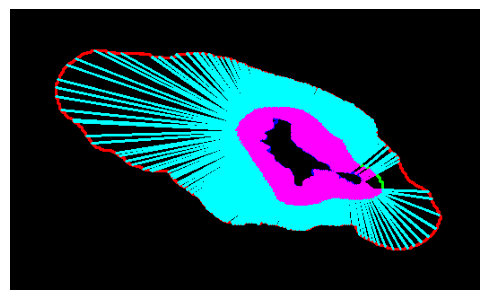

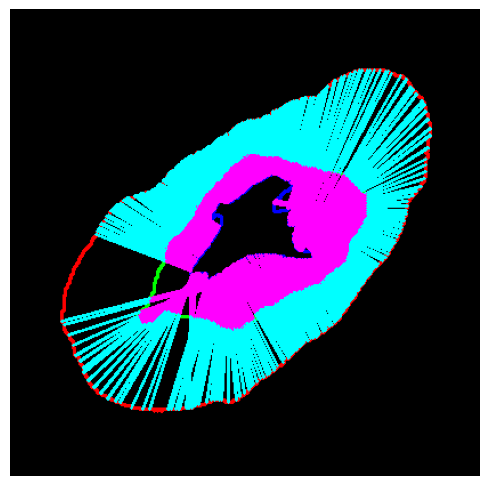

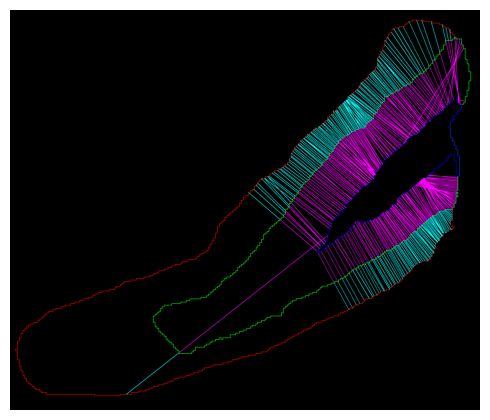

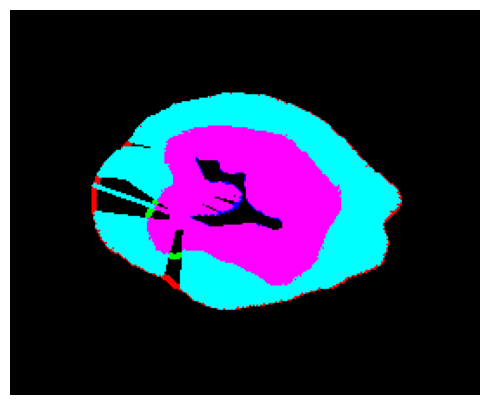

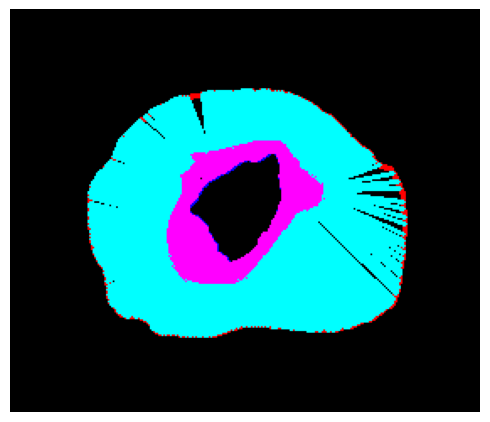

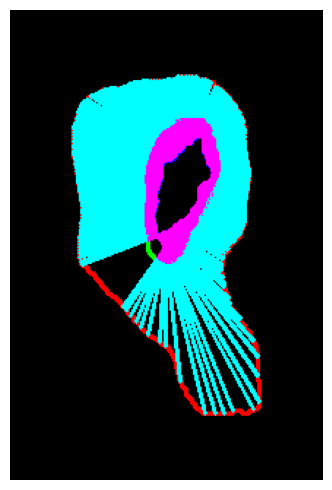

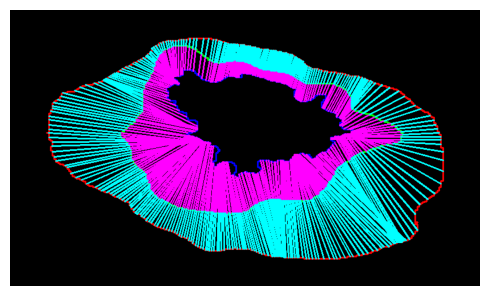

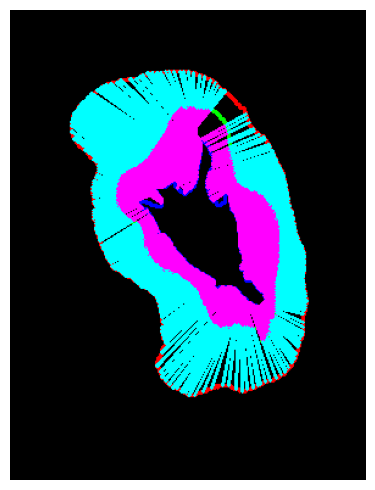

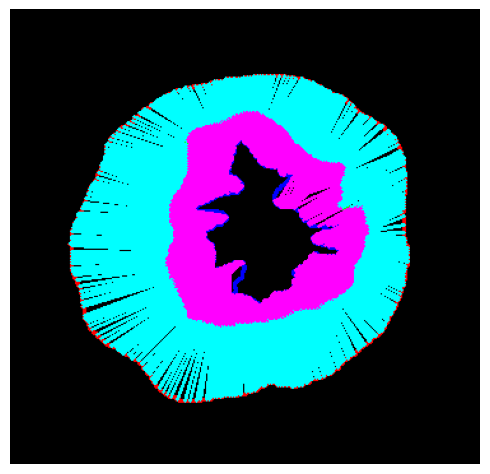

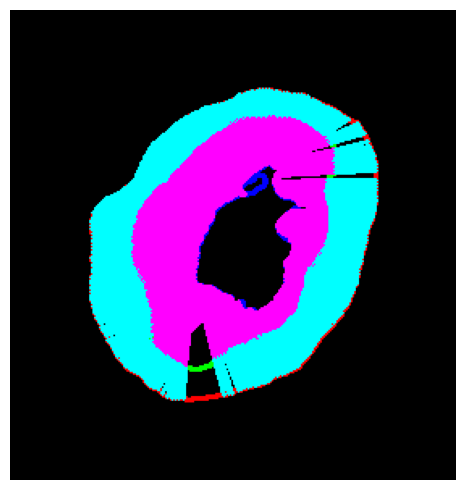

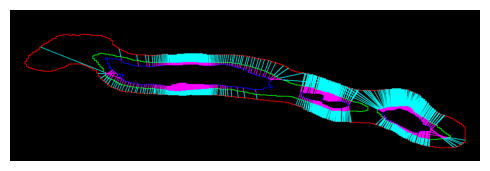

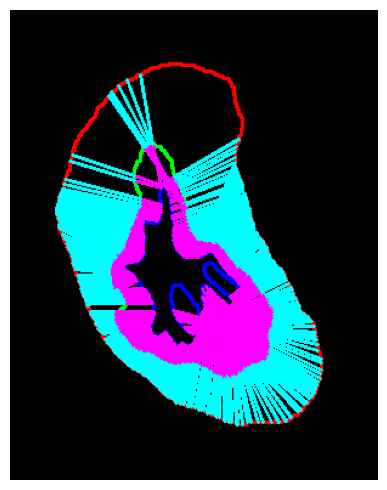

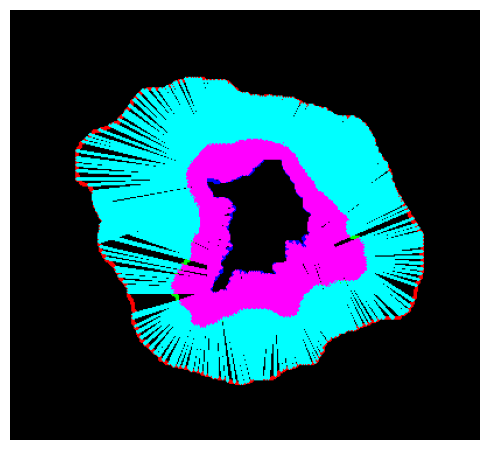

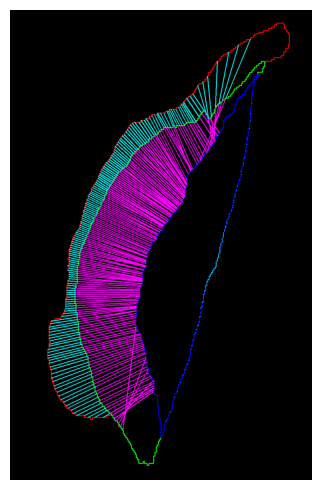

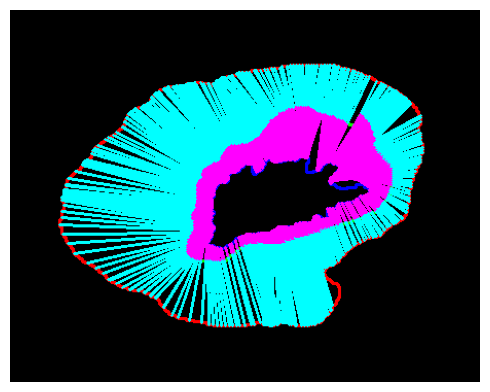

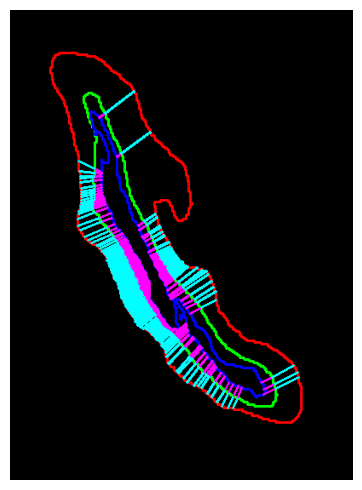

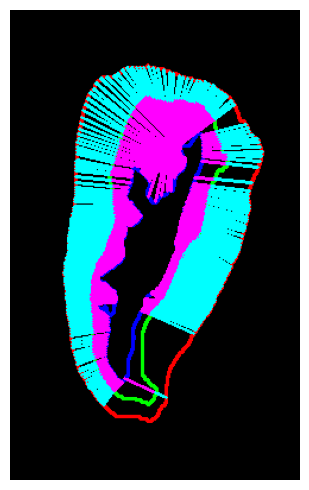

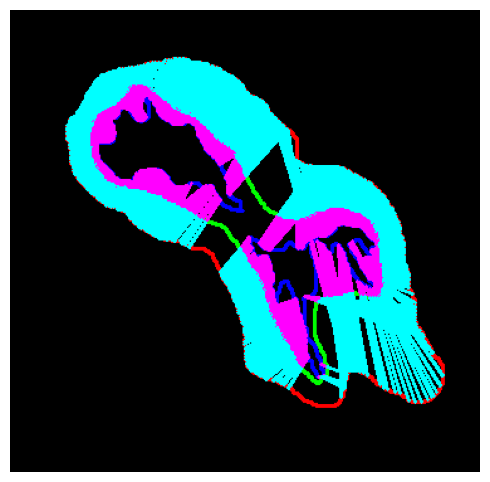

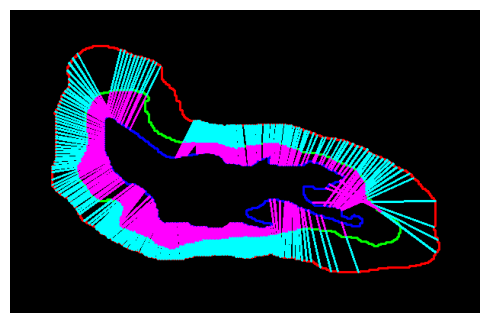

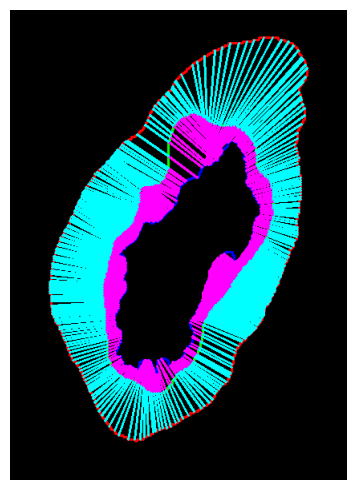

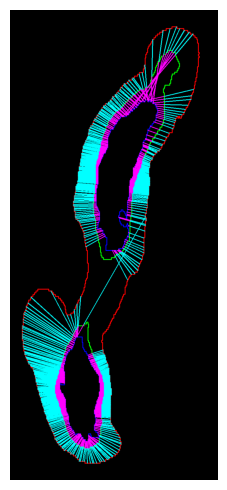

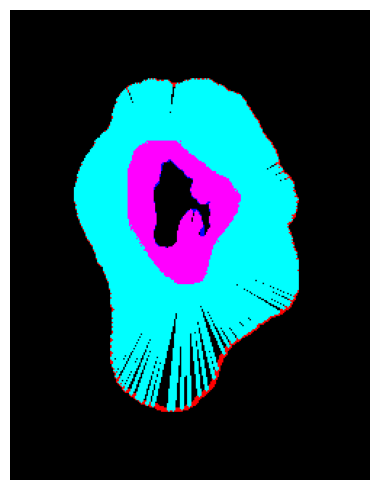

In [5]:
df = pd.DataFrame(columns = ['WSI_ID', 'Artery_ID', 'Area', 'Thickness_Media_Abs', 
                             'Thickness_Intima_Abs', 'Thickness_Wall_Abs'])

fails = []
for img_name in os.listdir(DIR_DL):
#     if img_name != "2_6130_A_0037288_A06_pred.png": continue
    
    if not img_name.endswith("pred.png"): continue
    # example img_name: 11_26609_000_011_L02_TRI_A01_pred.png
    wsi_id = img_name[:-13] # eg. 11_26609_000_011_L02_TRI
    artery_id = img_name[-12: -9] # eg. A01
    gt_name = img_name[:-8] +"gt.png" # eg. 11_26609_000_011_L02_TRI_A01_gt.png
#     print(img_name)
#     row = df_features_label.loc[df_features_label.loc[:, "WSI_Artery_ID"] == img_name[:-9]]
#     print("Label", row["Label"].values[0], 
#           "Media Average", round(row["Media Average"].values[0], 2), 
#           "Media Power", round(row["Media Power"].values[0], 2), 
#           "Intima Average", round(row["Intima Average"].values[0], 2), 
#           "Intima Power", round(row["Intima Power"].values[0], 2))
    input_path = os.path.join(DIR_TEST, "input", img_name[:-9]+".png")
    gt_path = os.path.join(DIR_DL, gt_name)
    pred_path = os.path.join(DIR_DL, img_name)
    
    input_img = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
    gt = cv2.cvtColor(cv2.imread(gt_path), cv2.COLOR_BGR2GRAY)
    pred = cv2.cvtColor(cv2.imread(pred_path), cv2.COLOR_BGR2GRAY)
    
    # all media/lumen/intima have to exist to measure thickness
    if len(np.unique(pred)) != 4: 
        fails.append(img_name)
        continue
    
    cnt_outer, cnts_middle, cnts_inner = get_three_cnts(pred)
    # vis contours on top of an artery
    input_w_cnts = plot_artery_ann(input_img, cnt_outer, cnts_middle, cnts_inner)
#     imshow_k_in_row([input_w_cnts])
    # vis only contours
    h, w = input_img.shape[:2]
    curr_ann = np.zeros((h, w, 3), np.uint8)
    curr_ann = plot_artery_ann(curr_ann, cnt_outer, cnts_middle, cnts_inner)
    dir_save = os.path.join(DIR_SAVE_FIGURE, wsi_id, artery_id)

    area_lumen = np.sum([cv2.contourArea(cnt) for cnt in cnts_inner])
    area_intima = np.sum([cv2.contourArea(cnt) for cnt in cnts_middle]) - area_lumen    
    area_media = cv2.contourArea(cnt_outer) - area_intima - area_lumen
    exist = False
    thick_media = []
    thick_intima = []
    for idx, cnt_middle in enumerate(cnts_middle):
        for idy, cnt_inner in enumerate(cnts_inner):
            if cnt_polygon_test(cnt_inner, cnt_middle):
                # radial lines intersecs with excludde should be discarded
                exclude = cnts_middle[:idx] + cnts_middle[idx+1:]+ cnts_inner[:idy] + cnts_inner[idy+1:]
                thick_media_sub, thick_intima_sub=measure_thickness(
                    cnt_outer, cnt_middle, cnt_inner, angle_width=15, exclude=exclude, 
                    vis=curr_ann, dir_save=dir_save)
                thick_media = thick_media_sub
                thick_intima = thick_intima_sub
                curr_area_intima = cv2.contourArea(cnt_middle)
                curr_area_lumen = cv2.contourArea(cnt_inner)
                row = {'WSI_ID':wsi_id, 'Artery_ID':artery_id, 
                       'Thickness_Media':thick_media, 'Thickness_Intima':thick_intima,
                       'Area_Media': area_media, 'Area_Intima': area_intima, 'Area_Lumen': area_lumen,
                       'Curr_Area_Intima': curr_area_intima, 'Curr_Area_Lumen': curr_area_lumen}
                df = df.append(row, ignore_index=True)
                exist = True
    if not exist:
        print("not exist")
#         cnt_middle, idx = get_largest_cnt(cnts_middle)
#         cnt_inner, idy = get_largest_cnt(cnts_inner)
#         area_inner = cv2.contourArea(cnt_inner)
#         # radial lines intersecs with excludde should be discarded
#         exclude = cnts_middle[:idx] + cnts_middle[idx+1:]+ cnts_inner[:idy] + cnts_inner[idy+1:]
#         # radial lines intersecs with excludde should be discarded

#         thick_media_sub, thick_intima_sub=measure_thickness(
#             cnt_outer, cnt_middle, cnt_inner, angle_width=15, exclude=exclude, 
#             vis=curr_ann, dir_save=dir_save)
#         thick_media = thick_media+thick_media_sub
#         thick_intima = thick_intima+thick_intima_sub
#         curr_area_intima = cv2.contourArea(cnt_middle)
#         curr_area_lumen = cv2.contourArea(cnt_inner)
#         row = {'WSI_ID':wsi_id, 'Artery_ID':artery_id, 
#                'Thickness_Media':thick_media, 'Thickness_Intima':thick_intima,
#                'Area_Media': area_media, 'Area_Intima': area_intima, 'Area_Lumen': area_lumen,
#                'Curr_Area_Intima': curr_area_intima, 'Curr_Area_Lumen': curr_area_lumen}
#         df = df.append(row, ignore_index=True)
#     imshow_k_in_row([vis_cnts])
    imshow_k_in_row([curr_ann])

In [6]:
path_to_save = os.path.join(DIR_SAVE_RESULTS, "thickness_dl.json")

df.to_json(path_to_save, orient="records", lines=True)

In [7]:
df.shape

(142, 13)

In [8]:
fails

[]

In [9]:
input_path

'/Users/jinzhou/Desktop/Paper_MIA/test/input/2_6128_A_0037277_A16.png'

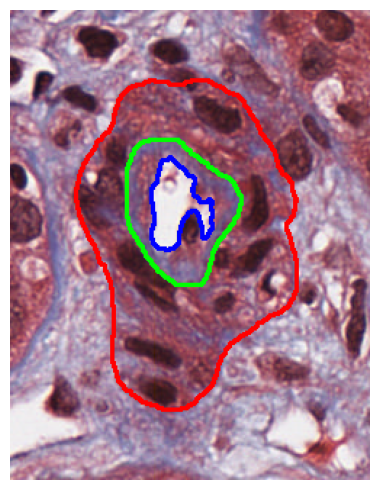

In [10]:
imshow_k_in_row([input_w_cnts])

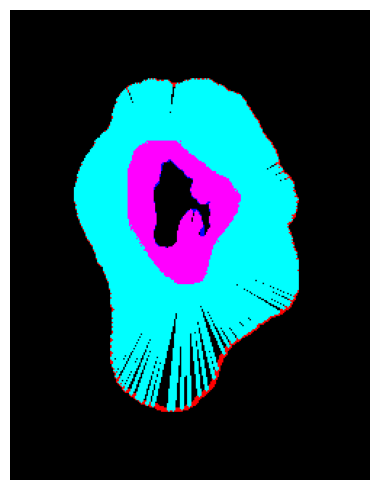

In [11]:
imshow_k_in_row([curr_ann])

In [12]:
len(cnts_inner)

1